# Read Input File and Define Libraries

In [102]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer




In [103]:
news_dataset = pd.read_csv('news_articles.csv')
print(news_dataset.shape)
print("Coumns :",news_dataset.columns)

(2096, 12)
Coumns : Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'label', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage'],
      dtype='object')


# Preprocessing Steps

In [104]:
print(news_dataset.isnull().sum())
#dropping null values
news_dataset.dropna(inplace=True)

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64


In [83]:
news_dataset.groupby('label').describe()

hasImage                                             
         count      mean       std  min  25%  50%  75%  max
label                                                      
Fake    1291.0  0.736638  0.440628  0.0  0.0  1.0  1.0  1.0
Real     754.0  0.834218  0.372132  0.0  1.0  1.0  1.0  1.0

# **EDA and Visualization**






Real and Fake News

In [105]:
#real vs fake
fig = px.pie(news_dataset,names='label',title='Real news vs. Fake News')
fig.show()

Types of Articles

In [106]:
print("The number and categories of unique type of articles are: ", len(news_dataset['type'].unique()), news_dataset['type'].unique())
fig = px.pie(news_dataset,names='type',title='Types of Articles')
fig.show()

The number and categories of unique type of articles are:  8 ['bias' 'conspiracy' 'fake' 'bs' 'satire' 'hate' 'junksci' 'state']


Languages of Articles

In [107]:
fig = px.pie(news_dataset,names='language',title='Languages of Articles')
fig.show()

Bigrams and Unigrams

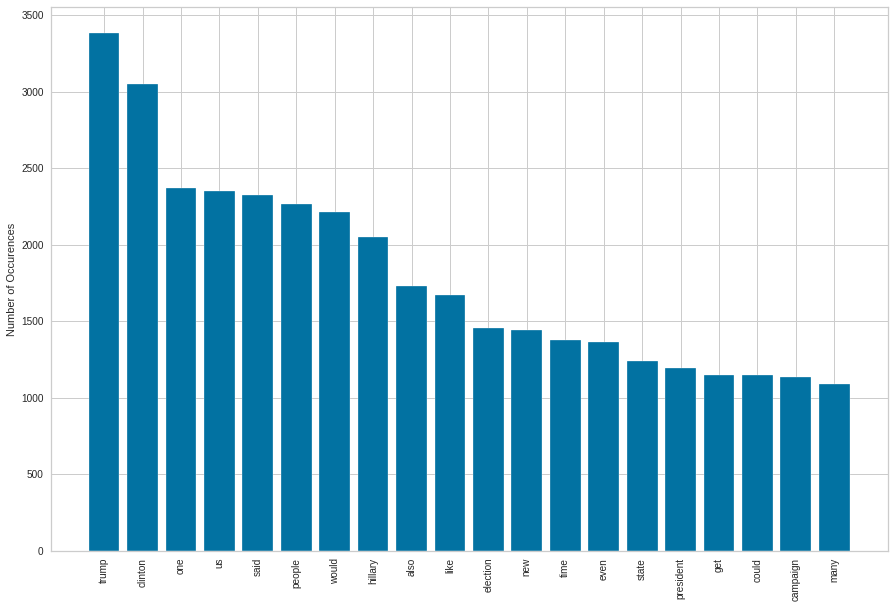

In [87]:
def get_top_n_words(corpus, n = None):
    """
    A function that returns the top 'n' unigrams used in the corpus
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return freq_sorted[:n]

def get_top_n_bigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

top_unigram = get_top_n_words(news_dataset['text_without_stopwords'], 20)
top_bigram = get_top_n_bigram(news_dataset['text_without_stopwords'], 20)
words = [i[0] for i in top_unigram]
count = [i[1] for i in top_unigram]

plt.figure(figsize=(15,10))
plt.bar(words, count,align='center')
plt.xticks(rotation=90)
plt.ylabel('Number of Occurences')
plt.show()

Word Cloud

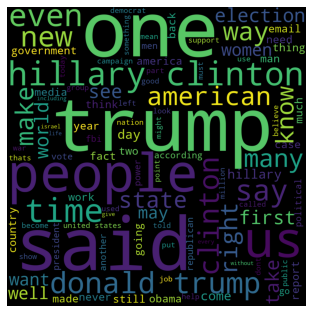

In [88]:
wc = WordCloud(background_color="black", max_words=100,
               max_font_size=256,
               random_state=42, width=1000, height=1000)
wc.generate(' '.join(news_dataset['text_without_stopwords']))
plt.imshow(wc)
plt.axis('off')
plt.show()

Visualizing top 10 fake and trustworthy news site

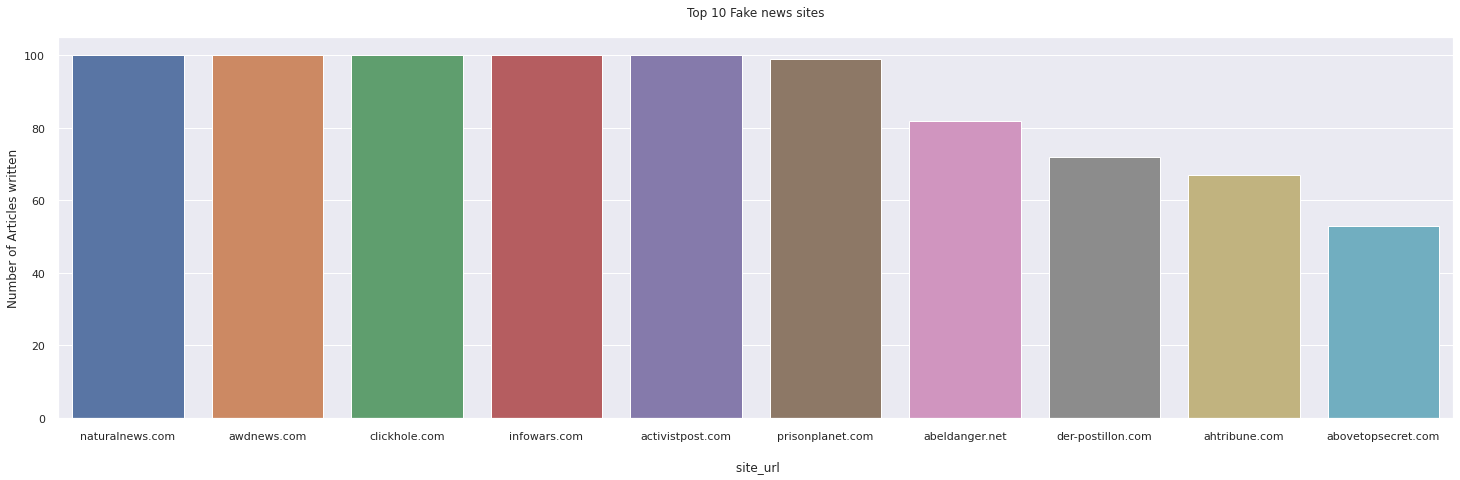

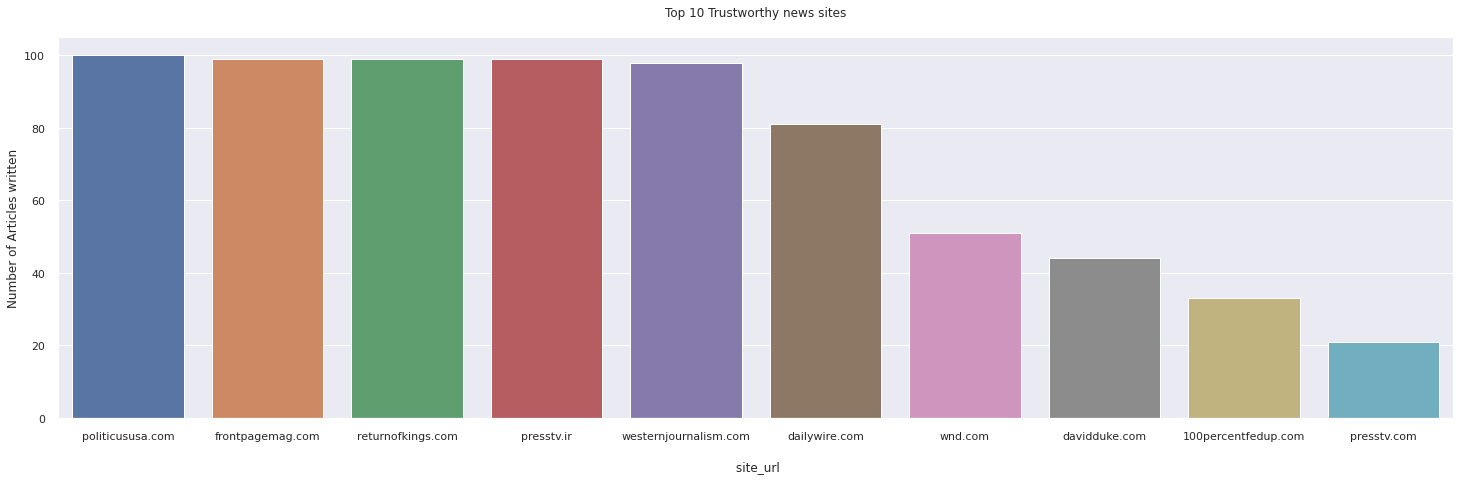

In [89]:
fake = news_dataset[news_dataset['label'] == 'Fake']['site_url'].value_counts().sort_values(ascending=False).head(10)
fake = pd.DataFrame(fake)
fake = fake.reset_index() # dataframe with top 10 fake news site



# Plotting
sns.set()
plt.figure(figsize=(25,7))
sns.barplot(x='index', y='site_url', data=fake)
plt.xlabel("\n site_url")
plt.ylabel("Number of Articles written")
plt.title("Top 10 Fake news sites\n")
plt.show()

real = news_dataset[news_dataset['label'] == 'Real']['site_url'].value_counts().sort_values(ascending=False).head(10)
real = pd.DataFrame(real)
real = real.reset_index() # dataframe with top 10 Trustworthy news site

# Plotting
sns.set()
plt.figure(figsize=(25,7))
sns.barplot(x='index', y='site_url', data=real)
plt.xlabel("\n site_url")
plt.ylabel("Number of Articles written")
plt.title("Top 10 Trustworthy news sites\n")
plt.show()

In [90]:
news_dataset.groupby(['language','label']).count()


author  published  ...  text_without_stopwords  hasImage
language label                     ...                                  
english  Fake     1217       1217  ...                    1217      1217
         Real      750        750  ...                     750       750
french   Fake        1          1  ...                       1         1
         Real        1          1  ...                       1         1
german   Fake       72         72  ...                      72        72
ignore   Real        3          3  ...                       3         3
spanish  Fake        1          1  ...                       1         1

[7 rows x 10 columns]

From EDA of above group by language and label it can be seen as German,Spanish languages only have fake lable where as English language have 60-40 percent ratio

In [91]:
news_dataset.groupby(['type','label']).count()

author  published  ...  text_without_stopwords  hasImage
type       label                     ...                                  
bias       Real      389        389  ...                     389       389
bs         Fake      598        598  ...                     598       598
conspiracy Fake      430        430  ...                     430       430
fake       Fake       15         15  ...                      15        15
hate       Real      244        244  ...                     244       244
junksci    Fake      102        102  ...                     102       102
satire     Fake      146        146  ...                     146       146
state      Real      121        121  ...                     121       121

[8 rows x 10 columns]

From EDA of above group by Type and label it can be seen as all the categories have almost even number of fake and real news

In [108]:
## Removing ".com" from site urls
urls = []
for url in news_dataset['site_url']:
    urls.append(url.split('.')[0])
news_dataset['site_url'] = urls

In [93]:
#taking the features
features = news_dataset[['site_url', 'text_without_stopwords']]
features.head(5)

features['url_text'] = features["site_url"].astype(str) + " " + features["text_without_stopwords"]
features.drop(['site_url', 'text_without_stopwords'], axis = 1, inplace = True)

features.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



url_text
0  100percentfedup print pay back money plus inte...
1  100percentfedup attorney general loretta lynch...
2  100percentfedup red state fox news sunday repo...
3  100percentfedup email kayla mueller prisoner t...
4  100percentfedup email healthcare reform make a...

In [94]:
X = features
y = news_dataset['label']
y = y.tolist()

In [95]:
#Splitting the dataset and using TF-IDF

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

tfidf_vectorizer = TfidfVectorizer(use_idf = True, stop_words = 'english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['url_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['url_text'])

In [96]:
tfidf_train = pd.DataFrame(X_train_tfidf.A, columns = tfidf_vectorizer.get_feature_names())
tfidf_train.head()

100percentfedup  21stcenturywire  ___   aa  ...  überzeugt  übrig  übrige  übte
0              0.0              0.0  0.0  0.0  ...        0.0    0.0     0.0   0.0
1              0.0              0.0  0.0  0.0  ...        0.0    0.0     0.0   0.0
2              0.0              0.0  0.0  0.0  ...        0.0    0.0     0.0   0.0
3              0.0              0.0  0.0  0.0  ...        0.0    0.0     0.0   0.0
4              0.0              0.0  0.0  0.0  ...        0.0    0.0     0.0   0.0

[5 rows x 39981 columns]

In [110]:
## Random Foresh 
rfc = RandomForestClassifier(n_estimators=100,random_state=1)
rfc.fit(tfidf_train, y_train)
y_pred = rfc.predict(X_test_tfidf)
RFscore = metrics.accuracy_score(y_test, y_pred)
print("The accuracy is : ", RFscore)

The accuracy is :  0.89453125


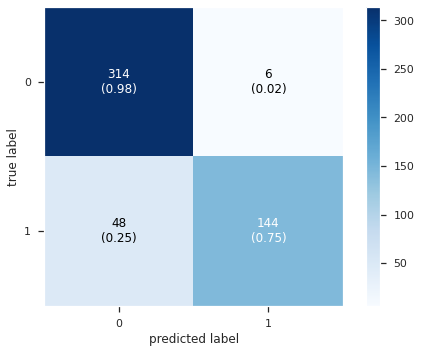

In [111]:
## Confusion Matrix
cm=confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [99]:
## Different Models in cross validation to check model validity
mod = []
cv_score=[]
model =[AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=5,random_state=1), RandomForestClassifier(n_estimators=100,random_state=1)]
for m in model:
    cv_score.append(cross_val_score(m, tfidf_train, y_train, scoring='accuracy', cv=4).mean())
    mod.append(m)
model_df=pd.DataFrame(columns=['model','cv_score'])
model_df['model']=mod
model_df['cv_score']=cv_score
model_df.sort_values(by=['cv_score'], ascending=True).style.background_gradient(subset=['cv_score'])

In [100]:
# As AdaBoostClassifier have good accuracy trying to define parameter n_estimators through loop
param={'n_estimators': [5,10,50,60,70,80,100,200]}
grid_Grd=GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), param_grid=param, cv=4, scoring='accuracy')
grid_Grd.fit(tfidf_train, y_train)
print(f"Best Estimator: {grid_Grd.best_params_} , Best Score : {grid_Grd.best_score_}")

Best Estimator: {'n_estimators': 10} , Best Score : 0.9856464860748476


In [101]:
## Adaboost Classifier
Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=10,random_state=1)
Adab.fit(tfidf_train, y_train)
y_pred3 = Adab.predict(X_test_tfidf)
ABscore = metrics.accuracy_score(y_test,y_pred3)
print("accuracy: %0.3f" %ABscore)

accuracy: 0.984


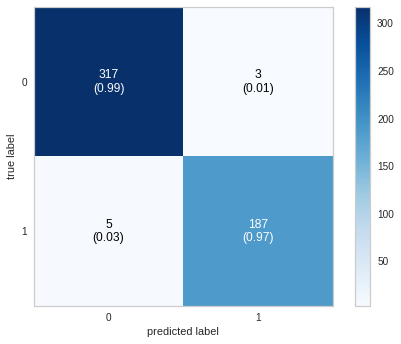

In [77]:
## Confusion Matrix for Adaboost Classifier
cm=confusion_matrix(y_test, y_pred3)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)


Summary : Both Random forest and Adaboost have good accuracy but with crossvalidation  random forest decreased from 89 to 86 but adaboost mantained almost same accuracy.Moreover adaboost has good accuracy score then random forest.As a Data scientist will go with Adaboost Classifier for the dataset.